# Exploration Triple & Graph

## Preliminary Operations

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import ast
import matplotlib.pyplot as plt
from collections import Counter
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns



## Dataset Claims

In [25]:
df_triple = pd.read_csv('C:\\Users\\Simone\\Documents\\Desktop\\Tesi_Magistrale\\triple_health.csv')
df_triple.head()

,Unnamed: 0,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,triplets
0,1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health","[{'head': 'False-Positives', 'type': 'facet of..."
1,2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer","[{'head': 'SBRT', 'type': 'medical condition t..."
2,3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health","[{'head': 'Ovarian Cancer', 'type': 'has part'..."
3,5,8713,Britain to reveal trial criteria for coronavir...,"April 7, 2020",British regulators will this week reveal appro...,Alistair Smout,Antibody tests show whether whether people hav...,,true,Health News,"[{'head': 'coronavirus', 'type': 'has effect',..."
4,7,2768,U.S. says results encouraging for healthcare d...,"January 30, 2014",The Obama administration on Thursday reported ...,David Morgan,As part of President Barack Obama’s healthcare...,,true,Health News,"[{'head': 'healthcare delivery reforms', 'type..."


In [16]:
df_triple.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      6019 non-null   int64 
 1   claim_id        6019 non-null   object
 2   claim           6019 non-null   object
 3   date_published  4366 non-null   object
 4   explanation     6019 non-null   object
 5   fact_checkers   6018 non-null   object
 6   main_text       6010 non-null   object
 7   sources         6009 non-null   object
 8   label           6010 non-null   object
 9   subjects        6010 non-null   object
 10  triplets        6019 non-null   object
dtypes: int64(1), object(10)
memory usage: 517.4+ KB


In [26]:
# Convertiamo 'head, type & tail' come sono segnati nel grafo PREDICATE,SUBJECT_NAME,OBJECT_NAME 

# Assicurati che la colonna 'triplets' contenga liste invece di stringhe
df_triple['triplets'] = df_triple['triplets'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Applica la funzione solo alle liste non vuote
df_triple['triplets'] = df_triple['triplets'].apply(lambda triple: [{'SUBJECT_NAME': t['head'], 'PREDICATE': t['type'], 'OBJECT_NAME': t['tail']} for t in triple] if triple else [])

#Applica la funzione che rende tutto maisucolo il predicato e aggiunge il trattino basso
df_triple['triplets'] = df_triple['triplets'].apply(lambda triple: [{'SUBJECT_NAME': t['SUBJECT_NAME'], 'PREDICATE': t['PREDICATE'].upper().replace(' ', '_'), 'OBJECT_NAME': t['OBJECT_NAME']} for t in triple] if triple else [])



In [27]:
df_triple[['claim', 'label', 'triplets']]

,claim,label,triplets
0,Annual Mammograms May Have More False-Positives,mixture,"[{'SUBJECT_NAME': 'False-Positives', 'PREDICAT..."
1,SBRT Offers Prostate Cancer Patients High Canc...,mixture,"[{'SUBJECT_NAME': 'SBRT', 'PREDICATE': 'MEDICA..."
2,"Study: Vaccine for Breast, Ovarian Cancer Has ...",true,"[{'SUBJECT_NAME': 'Ovarian Cancer', 'PREDICATE..."
3,Britain to reveal trial criteria for coronavir...,true,"[{'SUBJECT_NAME': 'coronavirus', 'PREDICATE': ..."
4,U.S. says results encouraging for healthcare d...,true,[{'SUBJECT_NAME': 'healthcare delivery reforms...
...,...,...,...
6014,Venezuela expands quarantine as number of coro...,true,"[{'SUBJECT_NAME': 'quarantine', 'PREDICATE': '..."
6015,The Sturgis motorcycle rally in 2020 resulted ...,unproven,"[{'SUBJECT_NAME': 'COVID-19 coronavirus', 'PRE..."
6016,AstraZeneca's infant respiratory drug prioriti...,true,"[{'SUBJECT_NAME': 'AstraZeneca', 'PREDICATE': ..."
6017,Testicular cancer deaths double with after 40 ...,true,[{'SUBJECT_NAME': 'death double with after 40 ...


In [31]:
with pd.option_context('max_colwidth', None,):
    print(df_triple[['triplets',]])

                                                                                                                                                                                                                                                                                                                                                                                                   triplets
0                                                                                                    [{'SUBJECT_NAME': 'False-Positives', 'PREDICATE': 'FACET_OF', 'OBJECT_NAME': 'Annual Mammograms'}, {'SUBJECT_NAME': 'False-Positives', 'PREDICATE': 'PART_OF', 'OBJECT_NAME': 'Annual Mammograms'}, {'SUBJECT_NAME': 'False-Positives', 'PREDICATE': 'SUBCLASS_OF', 'OBJECT_NAME': 'False-Positives'}]
1     [{'SUBJECT_NAME': 'SBRT', 'PREDICATE': 'MEDICAL_CONDITION_TREATED', 'OBJECT_NAME': 'Prostate Cancer'}, {'SUBJECT_NAME': 'SBRT', 'PREDICATE': 'MEDICAL_CONDITION_TREATED', 'OBJECT_NAME': 'Prostate Cancer'

In [19]:
def analyze_dataset(dataset):
    subject_names = []
    object_names = []
    predicates = []

    for index, row in dataset.iterrows():
        for triplet in row['triplets']:
            subject_names.append(triplet['SUBJECT_NAME'])
            object_names.append(triplet['OBJECT_NAME'])
            predicates.append(triplet['PREDICATE'])

    # Funzione per calcolare e stampare statistiche
    def print_stats(data, title):
        data_series = pd.Series(data)
        print(f"\nStatistiche per {title}:")
        print(f"Totale: {len(data_series)}")
        print(f"Unici: {data_series.nunique()}")
        print("Prime 20 stringhe:", data_series.value_counts().head(20).index.tolist())
        print("Ultime 20 stringhe:", data_series.value_counts().tail(20).index.tolist())

    # Calcolo delle statistiche per ogni categoria
    print_stats(subject_names, 'Subject Names')
    print_stats(object_names, 'Object Names')
    print_stats(predicates, 'Predicates')

# Esempio di utilizzo della funzione:
# analyze_dataset(df_triple)



In [28]:
analyze_dataset(df_triple)


Statistiche per Subject Names:
Totale: 20270
Unici: 9218
Prime 20 stringhe: ['coronavirus', 'COVID-19', 'HIV', 'Donald Trump', 'vaccine', 'breast cancer', 'China', 'medical marijuana', 'health care', 'President', 'Medicaid', 'Planned Parenthood', 'drug', 'Barack Obama', 'Medicare', 'CDC', 'Ebola', 'United States', 'flu', 'abortion']
Ultime 20 stringhe: ['Frailty Screening', 'Shands Hospital', 'Why Tortillas May Hold The Key To Healthier Babies', 'North Dakotans', 'chronic back pain', 'breast cancer research', 'Wrestling Wonsettlers', 'Physical', 'physical', '‘infestation’', 'Florida hospital', 'RETINAL SCANS', 'probable case', 'AbbVie', 'microwave', 'drops inhaled insulin program', 'P.E.', 'school health', '1st vaping-related lung injury', 'DTaP vaccine']

Statistiche per Object Names:
Totale: 20270
Unici: 6776
Prime 20 stringhe: ['coronavirus', 'China', 'U.S.', 'COVID-19', 'President', 'cancer', 'breast cancer', 'California', 'drug', 'Trump', 'Donald Trump', 'Texas', 'United States',

In [31]:
def plot_top_items(dataset):
    def extract_items(triplets, key):
        items = []
        for index, row in dataset.iterrows():
            for triplet in row[triplets]:
                items.append(triplet[key])
        return items

    def plot_top_30(data, title):
        data_series = pd.Series(data)
        top_30 = data_series.value_counts().head(30)
        
        plt.figure(figsize=(12, 10))  # Dimensioni più grandi per il grafico
        top_30.plot(kind='bar')
        plt.title(f'Top 30 {title}')
        plt.ylabel('Frequenza')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Estraiamo e grafichiamo per ogni categoria
    subject_names = extract_items('triplets', 'SUBJECT_NAME')
    object_names = extract_items('triplets', 'OBJECT_NAME')
    predicates = extract_items('triplets', 'PREDICATE')

    plot_top_30(subject_names, 'Subject Names')
    plot_top_30(object_names, 'Object Names')
    plot_top_30(predicates, 'Predicates')

# Esempio di utilizzo della funzione:
# plot_top_items(df_triple)



In [24]:
df_triple.columns

Index(['Unnamed: 0', 'claim_id', 'claim', 'date_published', 'explanation',
       'fact_checkers', 'main_text', 'sources', 'label', 'subjects',
       'triplets'],
      dtype='object')

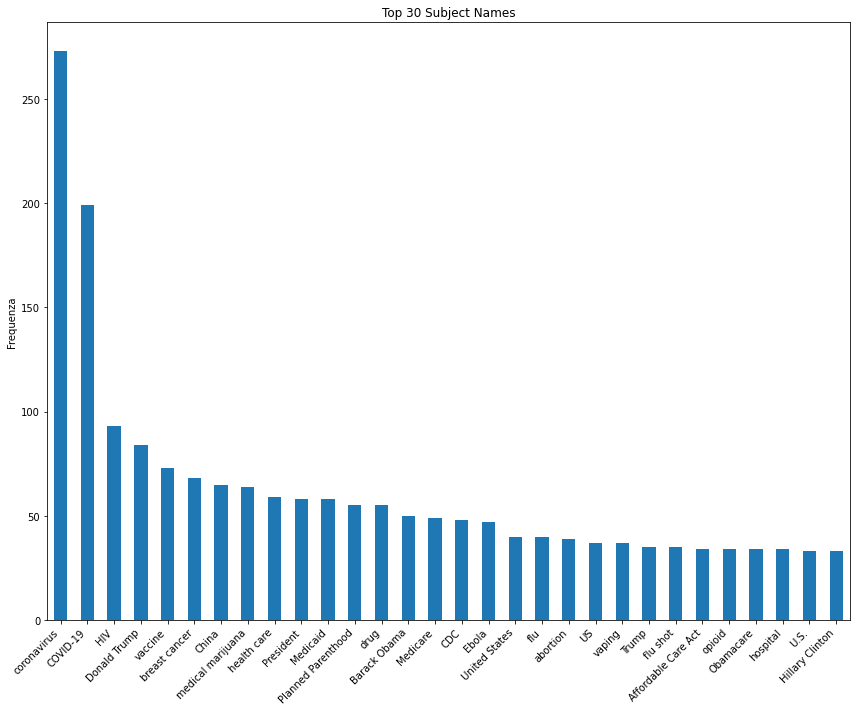

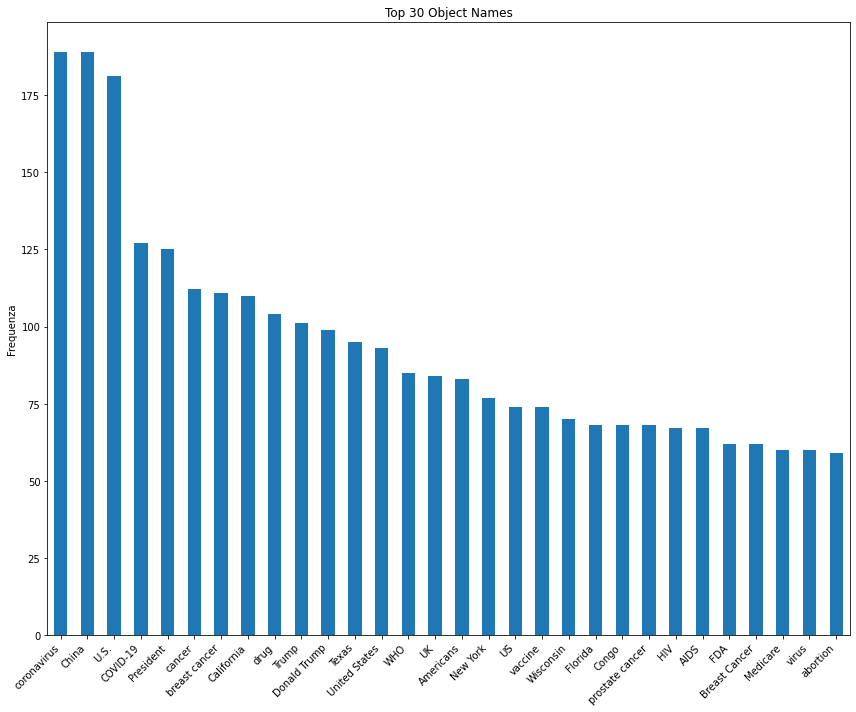

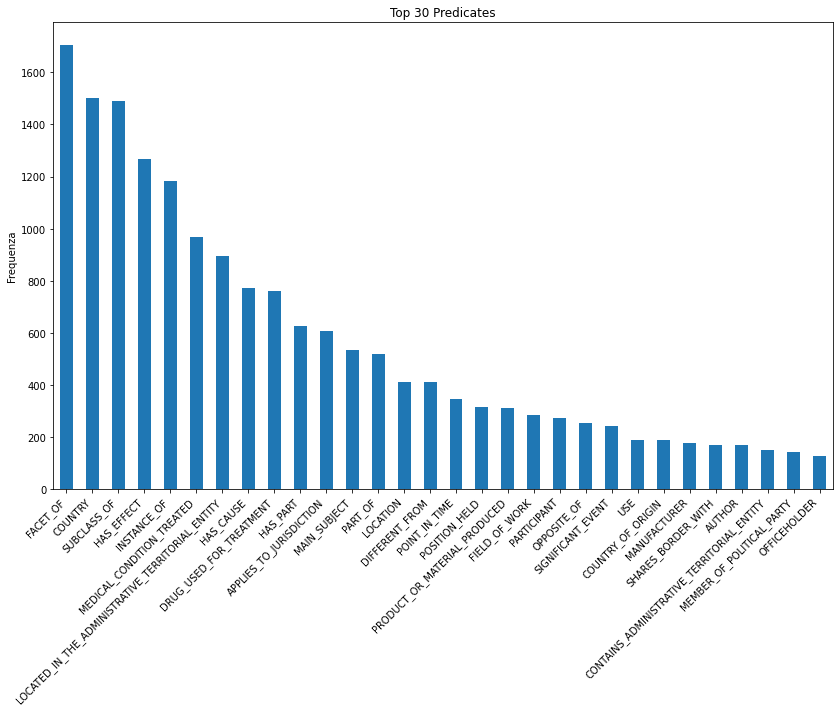

In [32]:
plot_top_items(df_triple)

In [45]:
plot_top_items_and_distribution(df_triple)

KeyError: 'PREDICATE'

## Dataset Knowledge Graph

In [36]:
kg = pd.read_csv('C:\\Users\\Simone\\Documents\\Desktop\\Tesi_Magistrale\\Data\\semmedVER43_2023_R_PREDICATION.csv.gz', encoding='ISO-8859-1', header=None, usecols=[3, 5, 9, 10]) #nrows=1000000
kg = kg[[3, 5, 9,10]]
nuovi_nomi_colonne = ["PREDICATE", "SUBJECT_NAME", "OBJECT_NAME","OBJECT_SEMTYPE"]  # Sostituisci con i nuovi nomi delle colonne
kg.columns = nuovi_nomi_colonne
kg.head(20)

,PREDICATE,SUBJECT_NAME,OBJECT_NAME,OBJECT_SEMTYPE
0,PROCESS_OF,Arboviruses,Lepus capensis,mamm
1,ISA,Tahyna virus,California Group Viruses,virs
2,ISA,Eyach virus,Coltivirus,virs
3,ISA,California Group Viruses,Arboviruses,virs
4,PROCESS_OF,Disease,Human,humn
5,CAUSES,Virus,Disease,dsyn
6,LOCATION_OF,Lepus capensis,Antibodies,aapp
7,PART_OF,Binding Protein,FHL1,aapp
8,PART_OF,COMPLEMENT FACTOR H|CFH,Borrelia burgdorferi,bact
9,PART_OF,Binding Protein,Borrelia burgdorferi,bact


In [37]:
def calculate_statistics(dataset):
    def print_stats(column):
        print(f"\nStatistiche per {column}:")
        print(f"Totale: {len(dataset[column])}")
        print(f"Unici: {dataset[column].nunique()}")
        print("Prime 20 stringhe:", dataset[column].value_counts().head(20).index.tolist())
        print("Ultime 20 stringhe:", dataset[column].value_counts().tail(20).index.tolist())

    for column in dataset.columns:
        print_stats(column)

# Esempio di utilizzo della funzione:
# calculate_statistics(df)


In [38]:
def plot_top_items(dataset):
    def plot_top_30(column):
        top_30 = dataset[column].value_counts().head(30)

        plt.figure(figsize=(12, 10))  # Dimensioni più grandi per il grafico
        top_30.plot(kind='bar')
        plt.title(f'Top 30 for {column}')
        plt.ylabel('Frequenza')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    for column in dataset.columns:
        plot_top_30(column)

# Esempio di utilizzo della funzione:
# plot_top_items(df)


In [39]:
calculate_statistics(kg)


Statistiche per PREDICATE:
Totale: 126268045
Unici: 68
Prime 20 stringhe: ['PROCESS_OF', 'LOCATION_OF', 'TREATS', 'PART_OF', 'ISA', 'AFFECTS', 'USES', 'COEXISTS_WITH', 'INTERACTS_WITH', 'CAUSES', 'ASSOCIATED_WITH', 'STIMULATES', 'ADMINISTERED_TO', 'INHIBITS', 'AUGMENTS', 'compared_with', 'DIAGNOSES', 'DISRUPTS', 'PRODUCES', 'PREDISPOSES']
Ultime 20 stringhe: ['same_as', 'NEG_PREVENTS', 'NEG_USES', 'NEG_METHOD_OF', 'NEG_PRECEDES', 'NEG_same_as', 'NEG_OCCURS_IN', 'NEG_higher_than', 'NEG_MEASURES', 'NEG_MANIFESTATION_OF', 'MEASUREMENT_OF', 'NEG_COMPLICATES', 'NEG_CONVERTS_TO', 'NEG_lower_than', 'NEG_MEASUREMENT_OF', 'PREP', 'NOM', 'VERB', '241', '1532']

Statistiche per SUBJECT_NAME:
Totale: 126268045
Unici: 364169
Prime 20 stringhe: ['Therapeutic procedure', 'Cells', 'Serum', 'Patients', 'Disease', 'Brain', 'Operative Surgical Procedures', 'Liver', 'Pharmaceutical Preparations', 'Body tissue', 'Lung', 'Plasma', 'Assay', 'Malignant Neoplasms', 'Obesity', 'tomography', 'Pharmacotherapy', 

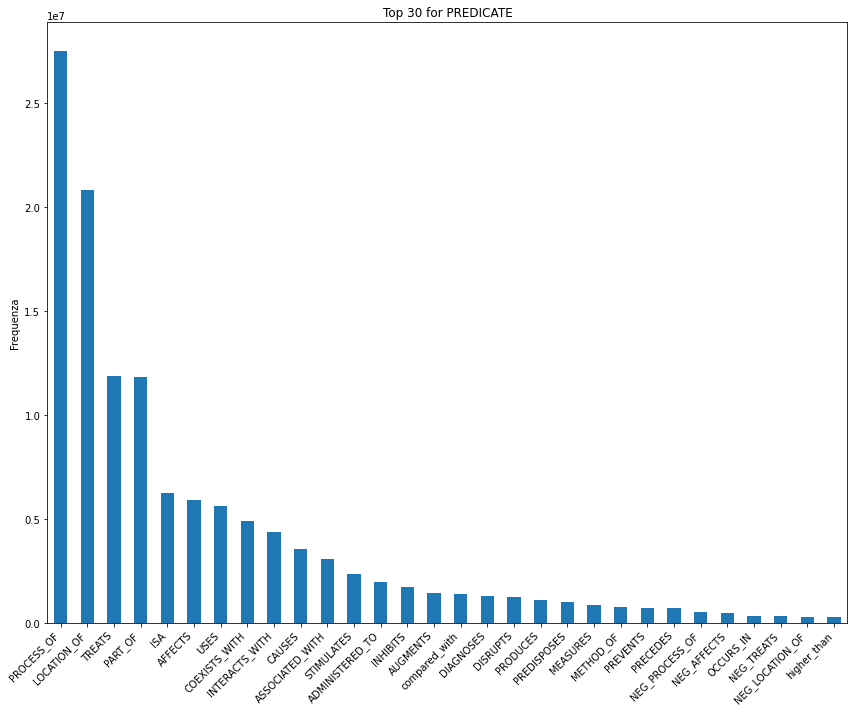

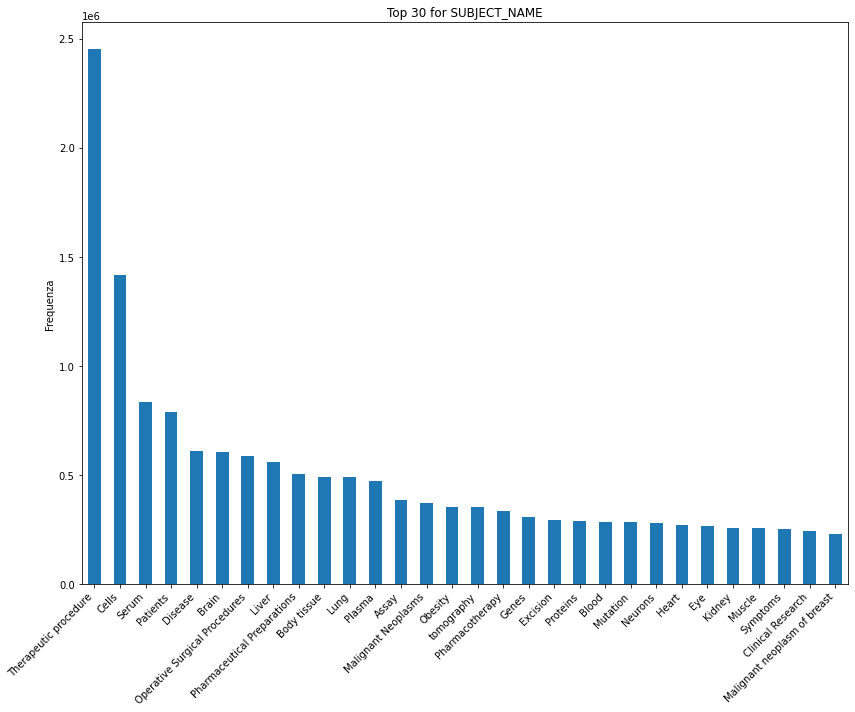

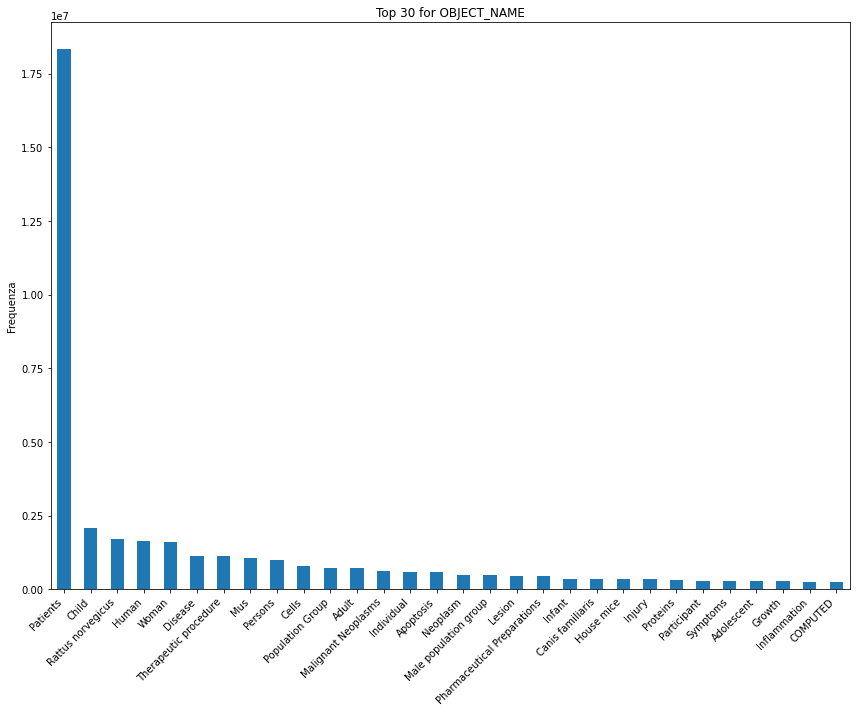

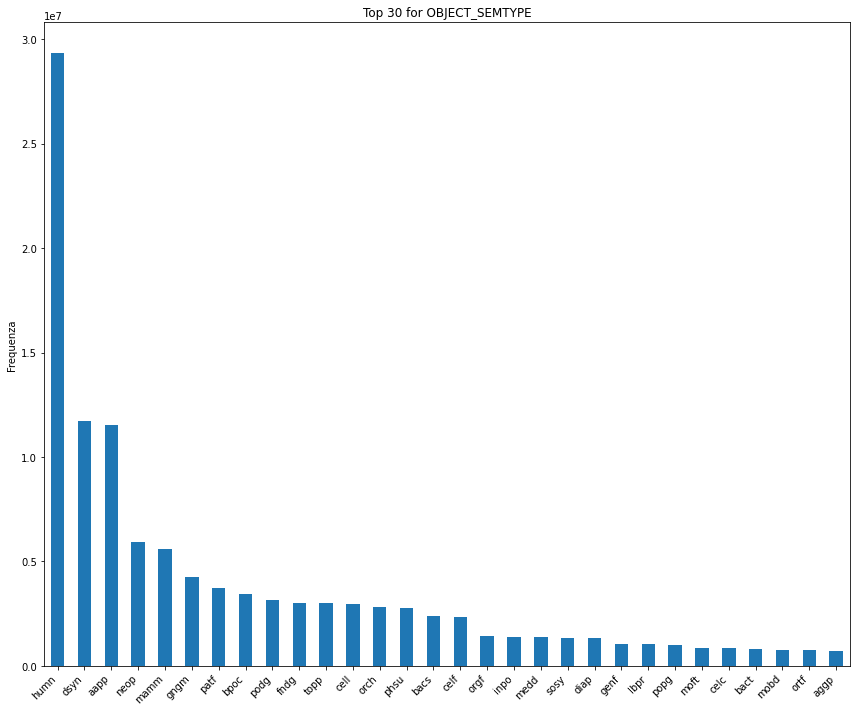

In [40]:
plot_top_items(kg)

## Knowledge Graph